In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data")

Extracting /tmp/data\train-images-idx3-ubyte.gz
Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz


In [6]:
learning_rate = 0.00001
height = 28   #image height
weight = 28   #image weight
channels = 1  #black and white
n_inputs = height * weight    #input nodes

conv1_fmaps = 32  #the number of maps
conv1_ksize = 3   #kernel size 3*3
conv1_stride = 1 # means weight and height both are 1 stride forward each piece.remember the strange picture, 1 filter 1 map 
                    # each map is a strange picture(physical way of human vision)    1 * 1 stride
conv1_pad = "SAME" #"SAME" padding "valid" no padding

conv2_fmaps = 64 #the number of maps
conv2_ksize = 3 
conv2_stride = 2
conv2_pad = "SAME"

maxpool_ksize = [1, 2, 2, 1]
maxpool_stride = [1, 2, 2, 1]
maxpool_pad = "VALID"

pool3_fmap = conv2_fmaps
fc_output_size = 256
output_size = 10

tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, weight, channels])
    Y = tf.placeholder(tf.float32, shape=[None, output_size], name="Y")
    
with tf.name_scope("conv"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize, strides=conv1_stride, 
                             padding=conv1_pad, activation=tf.nn.relu, name="conv1")
    #pool1 = tf.nn.max_pool(conv1, ksize=maxpool_ksize, strides=maxpool_stride, padding=maxpool_pad)
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize, strides=conv2_stride, 
                             padding=conv2_pad, activation=tf.nn.relu, name="conv2")
    
with tf.name_scope("max_pool"):
    #pool3 = tf.nn.max_pool(conv2, ksize=maxpool_ksize, strides=maxpool_stride, padding=maxpool_pad)
    #shape = pool3.shape
    shape = conv2.shape
    after_height = shape[1]
    after_weight = shape[2]
    after_channel = shape[3]
    flatten_fc_input = tf.reshape(conv2, shape=[-1, after_height*after_weight*after_channel])
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(flatten_fc_input, fc_output_size, activation=tf.nn.relu, name="fc1")
    logits = tf.layers.dense(fc1, output_size, name="logits")

with tf.name_scope("prediction"):
    y_proba = tf.nn.softmax(logits, name="probability")  #data normalization's prediction

with tf.name_scope("train"):
    #Y_change = tf.reshape(Y,(-1,1))
    output = tf.argmax(y_proba, axis=1)
    targets = tf.argmax(Y, axis=1)
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)   # normalization and loss function
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, targets, 1)  #top 1 evaluation
    #correct_prediction = tf.equal(output, targets)
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [3]:
from  sklearn.preprocessing import OneHotEncoder
def onehot(X):
    encoder = OneHotEncoder()
    Y = encoder.fit(X.reshape(-1,1))
    #Y = Y*0.98
    #Y = Y.toarray() + 0.01
    return Y
#X_batch, Y_batch = mnist.train.next_batch(1)
#a = onehot(Y_batch)
#a
encoder = onehot(mnist.train.labels)
def datapreprocessing(X, encoder):
    Y = encoder.transform(X)
    Y = Y * 0.98
    Y = Y.toarray() + 0.01
    return Y
#demo = [[1],[2],[3]]
#yaeryo = datapreprocessing(demo, encoder)
#yaeryo

In [4]:
mnist.train.next_batch(batch_size)
mnist.validation.images

NameError: name 'batch_size' is not defined

In [7]:
epochs = 100
batch_size = 100
best_value = 0
max_tolerate = 10000#20np.infty
without_process = 0
#X_train, Y_train_orignal = mnist.train.images, mnist.train.labels
#Y_train = datapreprocessing(Y_train_orignal.reshape(-1,1), encoder)
with tf.Session() as sess:
    init.run()
    for epoch in range(epochs): #epochs
        for iteration in range(mnist.train.num_examples // batch_size): #mnist.train.num_examples // batch_size
            X_batch, Y_orignal = mnist.train.next_batch(batch_size)
            Y_batch = datapreprocessing(Y_orignal.reshape(-1,1), encoder)
            #Y_batch = Y_batch.reshape(-1,1)
            #la = sess.run(xentropy, feed_dict={X:X_batch, Y:Y_batch})
            #print(la)
            #a, b, c, d = sess.run([y_proba, targets, training_op, correct], feed_dict={X:X_batch, Y:Y_batch})
            #print(b, "\n\n\n")
            #print(Y_orignal)
            a, acc_train = sess.run([training_op, accuracy], feed_dict={X:X_batch, Y:Y_batch})
            Y_validation = datapreprocessing(mnist.validation.labels.reshape(-1,1), encoder)
            #if iteration % 100 == 0:
            acc_validation = sess.run(accuracy, feed_dict={X:mnist.validation.images, Y:Y_validation})
                    #print(d)
            if acc_validation > best_value:
                best_value = acc_validation
                save_path = saver.save(sess, "./cnn_mnist_no_pooling.ckpt")
                without_process = 0
            else:
                without_process += 1
            
            if iteration % 10 == 0:
                print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", acc_validation, "Best value:", best_value)
                
        if without_process > max_tolerate:
            print("early stop!")
            break
        #acc_train = sess.run(accuracy, feed_dict={X:X_batch, Y:Y_batch})
        
        
        
        

0 Train accuracy: 0.2 Validation accuracy: 0.1236 Best value: 0.1236
0 Train accuracy: 0.26 Validation accuracy: 0.2168 Best value: 0.2168
0 Train accuracy: 0.3 Validation accuracy: 0.2968 Best value: 0.2968
0 Train accuracy: 0.43 Validation accuracy: 0.3968 Best value: 0.3968
0 Train accuracy: 0.52 Validation accuracy: 0.498 Best value: 0.498
0 Train accuracy: 0.46 Validation accuracy: 0.566 Best value: 0.566
0 Train accuracy: 0.73 Validation accuracy: 0.612 Best value: 0.612
0 Train accuracy: 0.59 Validation accuracy: 0.6554 Best value: 0.6554
0 Train accuracy: 0.69 Validation accuracy: 0.6902 Best value: 0.6902
0 Train accuracy: 0.71 Validation accuracy: 0.7106 Best value: 0.7106
0 Train accuracy: 0.7 Validation accuracy: 0.7272 Best value: 0.7272
0 Train accuracy: 0.75 Validation accuracy: 0.742 Best value: 0.742
0 Train accuracy: 0.69 Validation accuracy: 0.7448 Best value: 0.749
0 Train accuracy: 0.77 Validation accuracy: 0.7478 Best value: 0.749
0 Train accuracy: 0.72 Validation

2 Train accuracy: 0.87 Validation accuracy: 0.9044 Best value: 0.9086
2 Train accuracy: 0.95 Validation accuracy: 0.901 Best value: 0.9086
2 Train accuracy: 0.89 Validation accuracy: 0.904 Best value: 0.9086
2 Train accuracy: 0.91 Validation accuracy: 0.9058 Best value: 0.9086
2 Train accuracy: 0.92 Validation accuracy: 0.9066 Best value: 0.9086
2 Train accuracy: 0.94 Validation accuracy: 0.9062 Best value: 0.9086
2 Train accuracy: 0.92 Validation accuracy: 0.9082 Best value: 0.9086
2 Train accuracy: 0.93 Validation accuracy: 0.907 Best value: 0.9086
2 Train accuracy: 0.94 Validation accuracy: 0.908 Best value: 0.9094
2 Train accuracy: 0.93 Validation accuracy: 0.908 Best value: 0.9094
2 Train accuracy: 0.91 Validation accuracy: 0.9086 Best value: 0.9102
2 Train accuracy: 0.94 Validation accuracy: 0.9046 Best value: 0.9102
2 Train accuracy: 0.86 Validation accuracy: 0.9084 Best value: 0.9102
2 Train accuracy: 0.86 Validation accuracy: 0.9096 Best value: 0.9102
2 Train accuracy: 0.93 Va

4 Train accuracy: 0.95 Validation accuracy: 0.9212 Best value: 0.9262
4 Train accuracy: 0.9 Validation accuracy: 0.918 Best value: 0.9262
4 Train accuracy: 0.92 Validation accuracy: 0.9156 Best value: 0.9262
4 Train accuracy: 0.9 Validation accuracy: 0.918 Best value: 0.9262
4 Train accuracy: 0.89 Validation accuracy: 0.9098 Best value: 0.9262
4 Train accuracy: 0.89 Validation accuracy: 0.9128 Best value: 0.9262
4 Train accuracy: 0.94 Validation accuracy: 0.9116 Best value: 0.9262
4 Train accuracy: 0.91 Validation accuracy: 0.9184 Best value: 0.9262
4 Train accuracy: 0.9 Validation accuracy: 0.9252 Best value: 0.9262
4 Train accuracy: 0.93 Validation accuracy: 0.915 Best value: 0.9262
4 Train accuracy: 0.89 Validation accuracy: 0.917 Best value: 0.9262
4 Train accuracy: 0.95 Validation accuracy: 0.9188 Best value: 0.9262
4 Train accuracy: 0.94 Validation accuracy: 0.9094 Best value: 0.9262
4 Train accuracy: 0.94 Validation accuracy: 0.9224 Best value: 0.9262
4 Train accuracy: 0.87 Vali

KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from ./cnn_mnist_no_pooling.ckpt


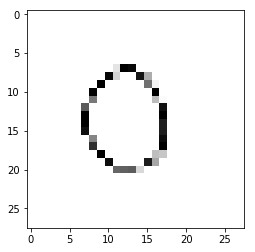

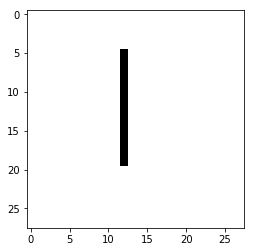

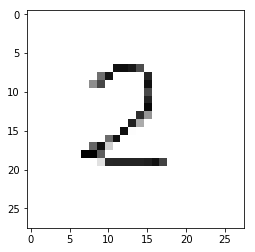

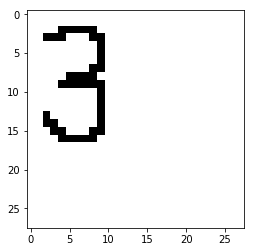

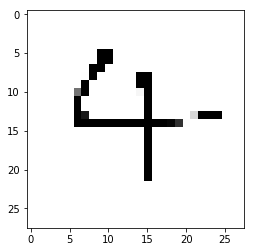

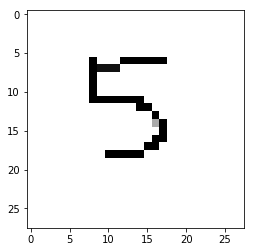

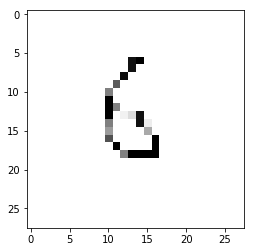

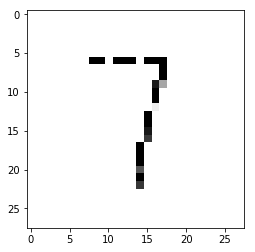

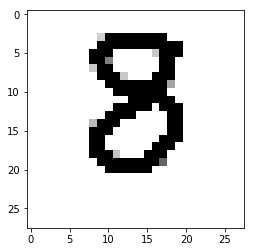

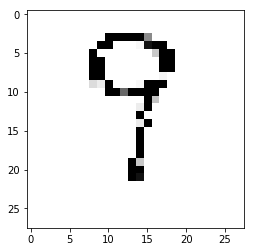

In [8]:
import scipy.misc
import glob
import matplotlib
with tf.Session() as sess:
    saver.restore(sess, "./cnn_mnist_no_pooling.ckpt")
    our_own_dataset = []
    our_own_target = []
    for image in glob.glob("F:\\hello\\ownhandwritting\\hw_?.png"):
        label = int(image[-5:-4])
        imarray = scipy.misc.imread(image,flatten=True)
        imarray = 255.0 - imarray.reshape(784)
        img_data = (imarray/255) * 0.98 + 0.01
        our_own_dataset.append(img_data)
        our_own_target.append(label)
        plt.imshow(img_data.reshape(28,28), cmap = matplotlib.cm.binary, interpolation="nearest")
        plt.show()
    Y_diy_data = datapreprocessing(np.array(our_own_target).reshape(-1,1), encoder)
    Y_final = output.eval(feed_dict={X:our_own_dataset, Y:Y_diy_data})
    

In [84]:
with tf.Session() as sess:
    baba = datapreprocessing(mnist.train.labels[:200].reshape(-1,1), encoder)
    saver.restore(sess, "./cnn_mnist.ckpt")
    yami = sess.run(accuracy, feed_dict={X:mnist.train.images[:200], Y:baba})
    yami

INFO:tensorflow:Restoring parameters from ./cnn_mnist.ckpt


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [576,256] rhs shape= [3136,256]
	 [[Node: save/Assign_17 = Assign[T=DT_FLOAT, _class=["loc:@fc1/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fc1/kernel/Adam_1, save/RestoreV2_17)]]

Caused by op 'save/Assign_17', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-83-1392169a5134>", line 71, in <module>
    saver = tf.train.Saver()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1218, in __init__
    self.build()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 751, in _build_internal
    restore_sequentially, reshape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 439, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 160, in restore
    self.op.get_shape().is_fully_defined())
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 56, in assign
    use_locking=use_locking, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [576,256] rhs shape= [3136,256]
	 [[Node: save/Assign_17 = Assign[T=DT_FLOAT, _class=["loc:@fc1/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fc1/kernel/Adam_1, save/RestoreV2_17)]]


In [9]:
yami

NameError: name 'yami' is not defined

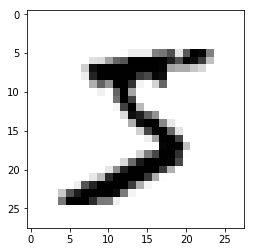

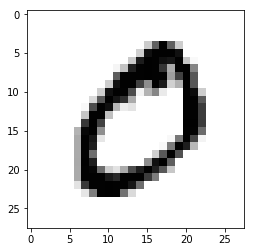

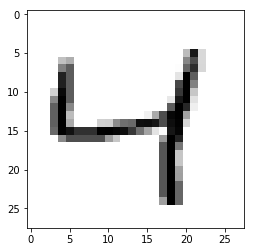

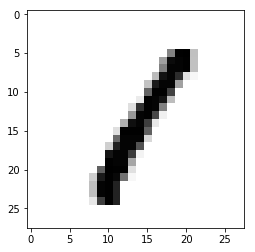

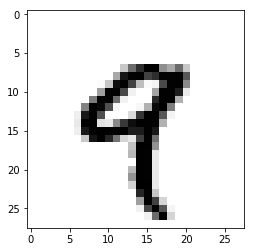

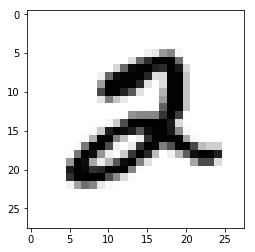

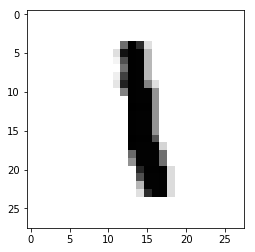

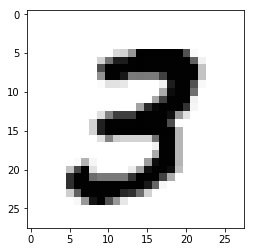

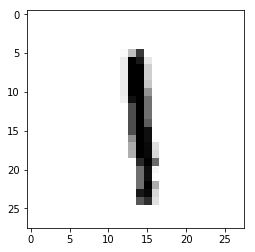

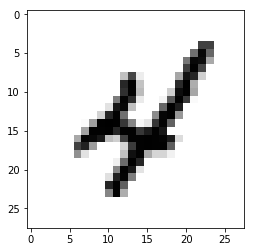

In [20]:
for i in range(10):
    plt.imshow(mnist.validation.images[i].reshape(28,28), cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.show()

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "./cnn_mnist.ckpt")
    yami1 = sess.run(output, feed_dict={X:mnist.validation.images[:10], Y:Y_validation[:10]})


INFO:tensorflow:Restoring parameters from ./cnn_mnist.ckpt


In [23]:
yami1

array([3, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int64)

In [10]:
Y_final

array([7, 5, 1, 7, 7, 7, 5, 7, 6, 3], dtype=int64)

In [21]:
epochs = 100
batch_size = 100
best_value = np.infty
max_tolerate = 20
with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, Y_batch = mnist.train.next_batch(batch_size)
            la = sess.run(logits, feed_dict={X:X_batch, Y:Y_batch})
            print(la)

[[  1.41377263e-02   1.51869521e-01  -2.76568234e-02   1.30271211e-01
    9.96214617e-03   5.08063920e-02  -5.66589646e-02  -1.02609843e-02
   -5.70401698e-02   8.39219838e-02]
 [  1.75514724e-02   4.84192483e-02  -5.13950586e-02   1.28278762e-01
    2.09635980e-02   2.55081244e-02  -2.79490668e-02  -4.62955274e-02
   -7.06721321e-02   1.77561864e-02]
 [ -6.73946589e-02   3.52692157e-02  -1.00799147e-02   1.07758373e-01
    2.15351991e-02   2.94561591e-03  -3.06681804e-02  -5.62702939e-02
   -3.60432714e-02   9.46262553e-02]
 [ -2.64555123e-02   6.33991584e-02   9.29373410e-03   1.25640243e-01
    1.62337627e-02   1.33476797e-02  -6.36639595e-02  -1.61272772e-02
   -7.56997988e-02   7.21060261e-02]
 [  6.08779266e-02   7.88769722e-02  -2.46520527e-02   7.01463446e-02
    7.18343887e-04   3.32654528e-02  -2.51606703e-02  -3.73028703e-02
   -2.01814584e-02   4.64263335e-02]
 [ -3.52681279e-02   5.10576740e-02   4.92508933e-02   5.04378788e-02
    2.47903075e-03   6.35680631e-02  -4.44407

[[ -3.19124237e-02   7.68748745e-02   3.71991768e-02   8.13686550e-02
   -1.64551474e-03  -1.29632205e-02  -6.75959587e-02  -6.09122869e-03
   -5.03202230e-02   5.63691631e-02]
 [  2.99435072e-02   8.82656425e-02   2.10200418e-02   5.65193854e-02
   -6.40471429e-02   3.65202166e-02  -5.96583635e-02  -4.17689607e-02
   -9.58786011e-02   8.31590891e-02]
 [ -6.12050155e-03   1.09609865e-01   3.41878347e-02   7.92669877e-02
    3.57432594e-03  -1.01489592e-02  -4.84262072e-02  -2.40751002e-02
   -4.43714410e-02   6.74067065e-02]
 [ -4.74066734e-02   7.88383111e-02   1.80398282e-02   1.00548275e-01
    5.67339640e-03   5.51601406e-03  -6.68771192e-02  -2.61500590e-02
   -2.24409811e-02   1.01836853e-01]
 [  5.47760772e-03   1.19177736e-01  -1.66792944e-02   8.40307772e-02
    2.22474318e-02   1.13557270e-02  -3.77341993e-02  -1.35362772e-02
   -6.10605404e-02   1.59067400e-02]
 [  1.35534918e-02   3.22759077e-02   3.65825519e-02   9.89286751e-02
    7.59949861e-03   4.94270585e-03  -6.92296

[[ -7.97458366e-03   6.90423995e-02   1.00777354e-02   1.05052665e-01
   -2.45638960e-03   2.35067271e-02  -2.73899846e-02  -2.21251547e-02
   -5.49316928e-02   7.62950480e-02]
 [  2.69522984e-03   6.31924570e-02   2.28985455e-02   1.69143409e-01
   -1.52621081e-03   4.69336659e-03  -6.52586818e-02  -7.47078136e-02
   -8.88414979e-02   1.00748464e-01]
 [ -1.15063554e-02   4.09421846e-02  -2.92306151e-02   9.80187058e-02
    3.73517238e-02  -8.12830310e-03  -4.10606451e-02  -2.83282921e-02
   -3.81643213e-02   3.57951969e-02]
 [  1.62572265e-02   2.57827472e-02  -2.70865224e-02   1.47382423e-01
    3.27035859e-02  -1.97051577e-02   2.24804506e-04  -7.55633116e-02
   -5.62698990e-02   4.06570956e-02]
 [  1.59661584e-02   1.19663805e-01   6.36395812e-02   7.53127560e-02
   -8.71069357e-02   2.89336871e-03  -1.08743027e-01  -7.98725486e-02
   -2.46897507e-02   8.75627100e-02]
 [ -5.93741089e-02   2.14966927e-02   5.74989207e-02   1.16133764e-02
   -5.41459136e-02   4.06405777e-02  -5.37393

[[  1.24924304e-02   8.77915509e-03   8.37658159e-03   6.25507608e-02
    2.32384279e-02   8.90133996e-03   4.50692512e-03  -3.08681875e-02
   -4.60827798e-02   6.38593733e-02]
 [  1.41421519e-02   8.81019011e-02  -1.40568987e-03   6.22570403e-02
   -1.61031131e-02   2.65932940e-02  -3.80367488e-02  -1.55928480e-02
   -4.51911762e-02   8.40832107e-03]
 [  5.01781283e-03   7.91934207e-02   4.04862463e-02   1.27547339e-01
   -1.53070595e-02  -5.47647895e-03  -7.50535131e-02  -3.14020291e-02
   -6.68960959e-02   9.67490822e-02]
 [  1.14771882e-02   8.90674219e-02  -1.11117475e-02   9.29809287e-02
    2.00562663e-02   2.09544525e-02  -2.39419919e-02  -2.39514690e-02
   -2.06583552e-02   3.99146676e-02]
 [  6.33983761e-02   1.15568079e-01  -1.67202950e-02   6.97356090e-02
   -2.42739655e-02   8.02907348e-02  -5.82689941e-02  -6.59676865e-02
   -6.97129220e-02   9.51333791e-02]
 [  3.10657155e-02   9.13293883e-02  -3.35526653e-02   6.20624572e-02
   -7.79330079e-03   4.90206368e-02  -2.13864

[[ -2.06186678e-02   6.82266131e-02   6.12061247e-02   7.64237270e-02
   -9.85196047e-03   2.95597930e-02  -8.20805877e-02  -1.11447582e-02
   -1.03119642e-01   4.08848822e-02]
 [  5.48404530e-02   5.01725301e-02   7.92256817e-02   9.38059539e-02
   -5.25834933e-02  -5.62809482e-02  -4.88914661e-02  -1.18266493e-01
   -2.65016370e-02   1.40751407e-01]
 [  1.95046403e-02   2.60551032e-02   4.06995974e-02  -1.01503786e-02
   -1.10236369e-02  -1.19329821e-02  -2.40137540e-02  -2.62473170e-02
   -1.37869576e-02   1.30166812e-02]
 [ -3.15004885e-02   1.72038469e-02   8.69964957e-02  -2.62351595e-02
   -5.90102673e-02   2.73052696e-02  -2.41558515e-02  -1.83318090e-02
   -1.00361481e-01   3.14223133e-02]
 [ -2.37903707e-02   4.99489121e-02   5.05132712e-02   7.08222836e-02
    3.16273570e-02   7.11426735e-02  -4.84517515e-02  -2.44724602e-02
   -6.59869760e-02   4.64774966e-02]
 [ -1.03568267e-02   6.73432350e-02  -1.92563087e-02   1.52663201e-01
    1.12834200e-02  -2.93616466e-02  -6.66422

KeyboardInterrupt: 

In [22]:
epochs = 100
batch_size = 100
best_value = np.infty
max_tolerate = 20
with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, Y_batch = mnist.train.next_batch(batch_size)
            la = sess.run(correct, feed_dict={X:X_batch, Y:Y_batch})
            print(la)

[False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False  True False False False  True False False False False False False
 False False False  True False False False False False False  True False
 False False False False False False False False  True  True False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[False  True False False False  True False False False False False False
  True False False False False  True False False  True False False False
  True False False False False False False False False False False  True
  True False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False 

[False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False  True False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True False
 False False False False]
[False False False False False False False False False False False False
 False False  True False False False False False False False  True False
 False False False False False False  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False 

KeyboardInterrupt: 

In [2]:
silm = tf.contrib.slim

In [3]:
haha = silm.conv2d

In [4]:
haha

<function tensorflow.contrib.layers.python.layers.layers.add_arg_scope.<locals>.func_with_args>

In [8]:
xixi = silm.arg_scope(silm.conv2d)

In [41]:
a = [[[[np.float32(1),np.float32(2.0),np.float32(3.0),np.float32(4.0)]]]]

In [42]:
a = np.array( a)
a.shape

(1, 1, 1, 4)

In [43]:
a.dtype

dtype('float32')

In [44]:
with silm.arg_scope([silm.conv2d]):
    haha = silm.conv2d(a, 32, [1, 1], stride=2)

In [45]:
haha

<tf.Tensor 'Conv_2/Relu:0' shape=(1, 1, 1, 32) dtype=float32>

In [47]:
haha.op.inputs[0]

<tf.Tensor 'Conv_2/BiasAdd:0' shape=(1, 1, 1, 32) dtype=float32>

In [48]:
with silm.arg_scope([tf.contrib.layers.conv2d]):
    convxixi = tf.contrib.layers.conv2d(a, 32, [1, 1], stride=2)

In [49]:
convxixi

<tf.Tensor 'Conv_3/Relu:0' shape=(1, 1, 1, 32) dtype=float32>